Final Trading Summary
Best MACD Parameters: Short EMA = 3, Long EMA = 15, Signal = 5
Total Trades Executed: 73
Total Profit from Trading: $-721.00
Total Transaction Costs: $74.00
MACD Strategy Final Value: $999,242.00
Buy & Hold Final Value: $1,005,138.19
MACD Trading Underperformed the Market!
Trade Log:
BUY 33 @ 6039.50 on 2025-02-09 18:20:00
SELL 33 @ 6041.25 on 2025-02-09 18:27:00 | Profit: $56.75
SHORT SELL 33 @ 6041.25 on 2025-02-09 18:27:00
STOP LOSS SHORT 33 @ 6045.75 on 2025-02-09 18:33:00 | Profit: $-149.50
SHORT SELL 33 @ 6047.00 on 2025-02-09 18:39:00
STOP LOSS SHORT 33 @ 6052.00 on 2025-02-09 18:46:00 | Profit: $-166.00
BUY 33 @ 6052.00 on 2025-02-09 18:46:00
TAKE PROFIT LONG 33 @ 6059.50 on 2025-02-09 18:52:00 | Profit: $246.50
SHORT SELL 33 @ 6059.75 on 2025-02-09 18:57:00
STOP LOSS SHORT 33 @ 6063.50 on 2025-02-09 19:00:00 | Profit: $-124.75
BUY 32 @ 6063.50 on 2025-02-09 19:00:00
STOP LOSS LONG 32 @ 6060.25 on 2025-02-09 19:04:00 | Profit: $-105.00
BUY 32 @ 6060.25 on 

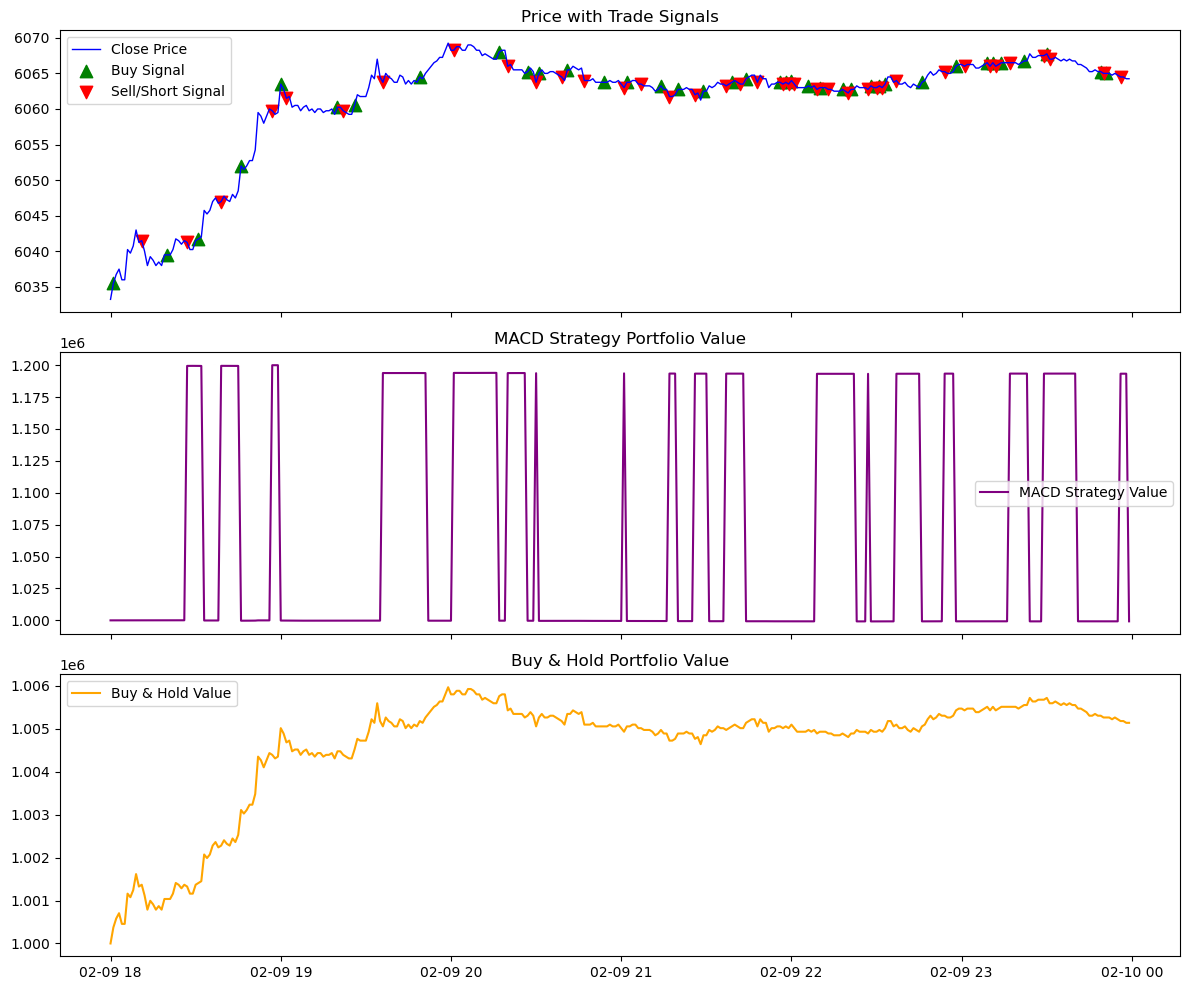

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# ===== Step 1: Load Data from CSV =====
file_path = "/Users/oscarolsen/Desktop/Algorithmic Trading/ES_1min_sample.csv"  
df = pd.read_csv(file_path)

# Ensure proper datetime formatting and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# ===== Step 2: Choose a Single Day =====
# For example, select the first available day in the data
chosen_date = df.index[0].date()
df_day = df[df.index.date == chosen_date].copy()

# ===== Step 3: Compute ATR for Dynamic Stops =====
df_day['H-L'] = df_day['high'] - df_day['low']
df_day['H-PC'] = (df_day['high'] - df_day['close'].shift(1)).abs()
df_day['L-PC'] = (df_day['low'] - df_day['close'].shift(1)).abs()
df_day['TR'] = df_day[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_day['ATR'] = df_day['TR'].rolling(window=14).mean()

# ===== Step 4: Grid Search for Best MACD Settings =====
short_ema_range = [3, 5, 8]
long_ema_range = [10, 15, 20]
signal_range = [3, 5, 7]

best_profit = -np.inf
best_params = None

# Loop over parameter combinations
for short_ema, long_ema, signal in product(short_ema_range, long_ema_range, signal_range):
    if short_ema >= long_ema:
        continue
    
    # Create a temporary copy so each iteration uses the same base data
    df_temp = df_day.copy()
    
    # Calculate MACD and its Signal Line using current parameters
    df_temp["MACD"] = df_temp["close"].ewm(span=short_ema, adjust=False).mean() - \
                      df_temp["close"].ewm(span=long_ema, adjust=False).mean()
    df_temp["Signal_Line"] = df_temp["MACD"].ewm(span=signal, adjust=False).mean()
    
    # Generate simple trade signals
    df_temp["Position"] = 0
    df_temp.loc[df_temp["MACD"] > df_temp["Signal_Line"], "Position"] = 1
    df_temp.loc[df_temp["MACD"] < df_temp["Signal_Line"], "Position"] = -1
    df_temp["Trade_Signal"] = df_temp["Position"].diff().replace({2: 1, -2: -1})
    
    # Simple backtest (only executing trades if profitable)
    initial_cash = 1000000
    cash = initial_cash
    shares = 0
    total_profit = 0
    transaction_cost = 1.00
    entry_price = 0

    for i in range(len(df_temp)):
        price = df_temp["close"].iloc[i]
        signal_val = df_temp["Trade_Signal"].iloc[i]
        
        if signal_val == 1:  # Buy signal
            shares = int(cash / (price * 10))
            if shares > 0 and cash >= shares * price + transaction_cost:
                cash -= shares * price + transaction_cost
                entry_price = price
        elif signal_val == -1 and shares > 0:  # Sell signal
            trade_profit = (price - entry_price) * shares - transaction_cost
            if trade_profit >= 0:
                cash += shares * price - transaction_cost
                total_profit += trade_profit
                shares = 0

    if total_profit > best_profit:
        best_profit = total_profit
        best_params = (short_ema, long_ema, signal)

# Apply the best MACD settings found
best_short_ema, best_long_ema, best_signal = best_params
df_day["MACD_Best"] = df_day["close"].ewm(span=best_short_ema, adjust=False).mean() - \
                      df_day["close"].ewm(span=best_long_ema, adjust=False).mean()
df_day["Signal_Best"] = df_day["MACD_Best"].ewm(span=best_signal, adjust=False).mean()

df_day["Position"] = 0
df_day.loc[df_day["MACD_Best"] > df_day["Signal_Best"], "Position"] = 1
df_day.loc[df_day["MACD_Best"] < df_day["Signal_Best"], "Position"] = -1
df_day["Trade_Signal"] = df_day["Position"].diff().replace({2: 1, -2: -1})

# ===== Step 5: Final Trading Execution with Dynamic Stops =====
initial_cash = 1000000
cash = initial_cash
position = 0         # positive for long, negative for short
entry_price = None   # price when the current position was opened
entry_atr = None     # ATR value at entry (for dynamic stops)
total_transaction_costs = 0
trade_log = []
total_trades = 0
total_profit = 0
portfolio_value = []

transaction_cost = 1.00

# Trade sizing: use 20% of available cash (limit per trade set to 500 units)
def calculate_trade_size(price, cash_available):
    max_trade_size = 500
    return min(max_trade_size, int((cash_available * 0.2) / price))

# Define dynamic stop multipliers (in ATR multiples)
stop_loss_multiplier = 1.0
take_profit_multiplier = 2.0

for i in range(len(df_day)):
    price = df_day["close"].iloc[i]
    signal_val = df_day["Trade_Signal"].iloc[i]
    current_atr = df_day["ATR"].iloc[i]
    
    # If ATR is not yet available, simply record portfolio value
    if np.isnan(current_atr):
        portfolio_value.append(cash if position == 0 else (cash + position * price))
        continue

    # ===== Check for Dynamic Stop-Loss / Take-Profit Conditions =====
    if position > 0:  # Long position
        stop_loss_long = entry_price - stop_loss_multiplier * entry_atr
        take_profit_long = entry_price + take_profit_multiplier * entry_atr
        if price >= take_profit_long:
            trade_profit = (price - entry_price) * position - transaction_cost
            cash += position * price - transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"TAKE PROFIT LONG {position} @ {price:.2f} on {df_day.index[i]} | Profit: ${trade_profit:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None
        elif price <= stop_loss_long:
            trade_profit = (price - entry_price) * position - transaction_cost
            cash += position * price - transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"STOP LOSS LONG {position} @ {price:.2f} on {df_day.index[i]} | Profit: ${trade_profit:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None

    elif position < 0:  # Short position
        stop_loss_short = entry_price + stop_loss_multiplier * entry_atr
        take_profit_short = entry_price - take_profit_multiplier * entry_atr
        if price <= take_profit_short:
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            cash -= price * abs(position) + transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"TAKE PROFIT SHORT {abs(position)} @ {price:.2f} on {df_day.index[i]} | Profit: ${trade_profit:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None
        elif price >= stop_loss_short:
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            cash -= price * abs(position) + transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"STOP LOSS SHORT {abs(position)} @ {price:.2f} on {df_day.index[i]} | Profit: ${trade_profit:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None

    # ===== Process New Trade Signals =====
    if signal_val == 1:
        # If a short position exists, cover it if profitable
        if position < 0:
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            if trade_profit >= 0:
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                total_transaction_costs += transaction_cost
                trade_log.append(f"COVER SHORT {abs(position)} @ {price:.2f} on {df_day.index[i]} | Profit: ${trade_profit:.2f}")
                total_trades += 1
                position = 0
                entry_price = None
                entry_atr = None
        # Open a new long position if no position is open
        if position == 0:
            shares = calculate_trade_size(price, cash)
            if shares > 0 and cash >= shares * price + transaction_cost:
                cash -= shares * price + transaction_cost
                total_transaction_costs += transaction_cost
                entry_price = price
                entry_atr = current_atr
                position = shares
                trade_log.append(f"BUY {shares} @ {price:.2f} on {df_day.index[i]}")
                total_trades += 1

    elif signal_val == -1:
        # If a long position exists, exit if profitable
        if position > 0:
            trade_profit = (price - entry_price) * position - transaction_cost
            if trade_profit >= 0:
                cash += position * price - transaction_cost
                total_profit += trade_profit
                total_transaction_costs += transaction_cost
                trade_log.append(f"SELL {position} @ {price:.2f} on {df_day.index[i]} | Profit: ${trade_profit:.2f}")
                total_trades += 1
                position = 0
                entry_price = None
                entry_atr = None
        # Open a new short position if no position is open
        if position == 0:
            shares = calculate_trade_size(price, cash)
            if shares > 0:
                cash += shares * price - transaction_cost
                total_transaction_costs += transaction_cost
                entry_price = price
                entry_atr = current_atr
                position = -shares
                trade_log.append(f"SHORT SELL {shares} @ {price:.2f} on {df_day.index[i]}")
                total_trades += 1

    # Update portfolio value based on current position
    if position > 0:
        portfolio_value.append(cash + position * price)
    elif position < 0:
        portfolio_value.append(cash + (entry_price - price) * abs(position))
    else:
        portfolio_value.append(cash)

# ===== Final Closing of Open Positions =====
final_price = df_day["close"].iloc[-1]
if position > 0:
    trade_profit = (final_price - entry_price) * position - transaction_cost
    cash += position * final_price - transaction_cost
    total_profit += trade_profit
    total_transaction_costs += transaction_cost
    trade_log.append(f"FINAL SELL {position} @ {final_price:.2f} on {df_day.index[-1]} | Profit: ${trade_profit:.2f}")
    position = 0
elif position < 0:
    trade_profit = (entry_price - final_price) * abs(position) - transaction_cost
    cash -= final_price * abs(position) + transaction_cost
    total_profit += trade_profit
    total_transaction_costs += transaction_cost
    trade_log.append(f"FINAL COVER SHORT {abs(position)} @ {final_price:.2f} on {df_day.index[-1]} | Profit: ${trade_profit:.2f}")
    position = 0

portfolio_value[-1] = cash
df_day = df_day.iloc[:len(portfolio_value)]
df_day["MACD_Strategy_Value"] = portfolio_value

# Create a Buy & Hold benchmark for comparison
df_day["Buy_Hold_Value"] = initial_cash * (df_day["close"] / df_day["close"].iloc[0])

# ===== Step 6: Print Results =====
print("="*60)
print("Final Trading Summary")
print("="*60)
print(f"Best MACD Parameters: Short EMA = {best_short_ema}, Long EMA = {best_long_ema}, Signal = {best_signal}")
print(f"Total Trades Executed: {total_trades}")
print(f"Total Profit from Trading: ${total_profit:,.2f}")
print(f"Total Transaction Costs: ${total_transaction_costs:,.2f}")
print("="*60)
print("MACD Strategy Final Value: ${:,.2f}".format(df_day["MACD_Strategy_Value"].iloc[-1]))
print("Buy & Hold Final Value: ${:,.2f}".format(df_day["Buy_Hold_Value"].iloc[-1]))
if df_day["MACD_Strategy_Value"].iloc[-1] > df_day["Buy_Hold_Value"].iloc[-1]:
    print("MACD Trading Outperformed the Market!")
else:
    print("MACD Trading Underperformed the Market!")
print("="*60)
print("Trade Log:")
for log in trade_log:
    print(log)

# ===== Step 7: Visualize the Results =====
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Subplot 1: Price with Trade Signals
axs[0].plot(df_day.index, df_day["close"], label="Close Price", color="blue", linewidth=1)
buy_signals = df_day[df_day["Trade_Signal"] == 1]
sell_signals = df_day[df_day["Trade_Signal"] == -1]
axs[0].scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy Signal", s=80)
axs[0].scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell/Short Signal", s=80)
axs[0].set_title("Price with Trade Signals")
axs[0].legend()

# Subplot 2: MACD Strategy Portfolio Value
axs[1].plot(df_day.index, df_day["MACD_Strategy_Value"], label="MACD Strategy Value", color="purple")
axs[1].set_title("MACD Strategy Portfolio Value")
axs[1].legend()

# Subplot 3: Buy & Hold Benchmark
axs[2].plot(df_day.index, df_day["Buy_Hold_Value"], label="Buy & Hold Value", color="orange")
axs[2].set_title("Buy & Hold Portfolio Value")
axs[2].legend()

plt.tight_layout()
plt.show()


